In [2]:
from typing import TypedDict
from langgraph.graph import StateGraph,START,END

In [4]:
class PasswordState(TypedDict):
    password: str
    strength: str
    suggestions: str


In [9]:
def evaluate_strength(state: PasswordState) -> PasswordState:
    password = state['password']
    length = len(password)>=8
    has_upper = any(c.isupper() for c in password)
    has_lower = any(c.islower() for c in password)
    has_digit = any(c.isdigit() for c in password)
    has_special = any( c in '!@#$%^&*()_+-=[]{}|;:,.<>?/' for c in password)

    score = sum([length, has_upper, has_lower, has_digit, has_special])
    if score == 5:
        state['strength'] = "strong"
    elif score >= 3:
        state['strength'] = "medium"
    else:
        state['strength'] = "weak"
    return state

def suggest_improvements(state: PasswordState) -> PasswordState:
    if state['strength'] == "strong":
        state['suggestions']='Your password is strong. No improvements needed.'
        return state
    password = state['password']
    suggestions = []
    if len(password) < 8:
        suggestions.append("Make it at least 8 characters long.")
    if not any(c.isupper() for c in password):
        suggestions.append("Include uppercase letters.")
    if not any(c.islower() for c in password):
        suggestions.append("Include lowercase letters.")
    if not any(c.isdigit() for c in password):
        suggestions.append("Include digits.")
    if not any( c in '!@#$%^&*()_+-=[]{}|;:,.<>?/' for c in password):
        suggestions.append("Include special characters.")
    state['suggestions'] = " ".join(suggestions)
    return state    


In [ ]:
graph = StateGraph(PasswordState)
graph.add_node("evaluate_strength", evaluate_strength)
graph.add_node("suggest_improvements", suggest_improvements)

graph.add_edge(START, "evaluate_strength")
graph.add_edge("evaluate_strength", "suggest_improvements")
graph.add_edge("suggest_improvements", END)


In [ ]:
pass_workflow = graph.compile()


In [ ]:
inital_state = {
    "password": "P@ssw0rd"
}
final_state = pass_workflow.invoke(inital_state)
print(final_state)


{'password': 'P@ssw0rd', 'strength': 'strong', 'suggestions': 'Your password is strong. No improvements needed.'}


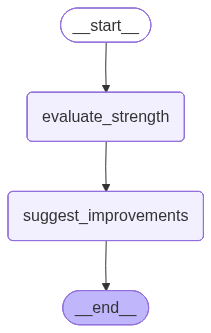

In [16]:
from IPython.display import Image

# Get the PNG data
png_data = pass_workflow.get_graph().draw_mermaid_png()

# Handle list case
if isinstance(png_data, list):
    png_data = b''.join(png_data)

# Save to file
with open('workflow_graph.png', 'wb') as f:
    f.write(png_data)

# Display from file
Image('workflow_graph.png')

In [19]:
from dotenv import load_dotenv
from langgraph.graph import StateGraph,END,START
from typing import TypedDict
from langchain_groq import ChatGroq
import os

/home/lang-chain/miniconda3/envs/Agentic_AI_MCP_RAG_Chat/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [20]:
load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

In [29]:
model  = ChatGroq(
    model = 'llama-3.1-8b-instant',
    api_key = GROQ_API_KEY,
    temperature = 0.7,
    max_tokens = 2048
)

In [30]:
class ChatState(TypedDict):
    question:str
    answer:str


In [31]:
def question_answer(state:ChatState) -> ChatState:
    question = state["question"]
    prompt = f"Answer the following Question:{question}"
    answer  = model.invoke(prompt).content
    state['answer'] = answer
    return state
    

In [32]:
graph = StateGraph(ChatState)
graph.add_node("question_answer", question_answer)
graph.add_edge(START,"question_answer")
graph.add_edge("question_answer", END)

In [33]:
llm_workflow = graph.compile()

In [34]:
inital_state={
    "question": "What is the capital of France?"
}
final_state = llm_workflow.invoke(inital_state)
print(final_state)

{'question': 'What is the capital of France?', 'answer': 'The capital of France is Paris.'}
